#### Get data

In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error

import statsmodels.api as sm

In [251]:
input_file = "reg_combined_df.csv"
full_data_raw = pd.read_csv(input_file, index_col=0)
full_data = full_data_raw.copy()

# Convert segment to str
full_data["segment"] = full_data["segment"].astype(str)

In [252]:
# Obtain income data by number of thousands
full_data["income"] = full_data["income"] / 1000
full_data = full_data.rename(columns={"income": "income_k"})

# Obtain time_since_last_txn in terms of days
full_data["time_since_last_txn"] = round((full_data["time_since_last_txn"] / 24), 2)

#### Check data

In [253]:
# Check differences in values for numeric columns between the 2 responses (0/1)
def check_num_cols_mean(data):
    numeric_cols_df = data.select_dtypes('number')
    return numeric_cols_df.groupby("offer_completed").mean().round(2)

In [254]:
check_num_cols_mean(full_data)

,age,income_k,reward,difficulty,duration,num_channels,txn_amt,used_email,used_web,used_social,used_mobile,offer_viewed,received_time,time_since_last_txn,last_txn_amt,ave_txn_amt,num_txn_past_week,num_offers_past_week
offer_completed,,,,,,,,,,,,,,,,,,
0,52.98,61.50,3.48,6.19,5.73,3.17,NaN,1.0,0.72,0.55,0.9,0.65,327.15,11.26,8.13,8.01,1.50,0.86
1,55.83,69.43,4.95,9.31,7.32,3.43,20.83,1.0,0.89,0.65,0.9,0.82,338.34,8.56,14.29,14.26,1.88,0.89


In [255]:
def plot_cat_count_distribution(data, col):
    count_df = data.groupby(["offer_completed", col])[col].value_counts().reset_index(name="count")
    plt.figure(figsize=(6,4))
    sns.barplot(data=count_df, x="count", y=col, hue="offer_completed", palette={0: "cornflowerblue", 1: "orange"})
    plt.show()

# Only checks for gender and offer_type categorical variables
def check_cat_cols_distribution(data):
    cat_cols = data.select_dtypes('object').columns.to_list() + ["offer_completed"]
    cat_cols_df = data[cat_cols]
    plot_cat_count_distribution(cat_cols_df, "gender")
    plot_cat_count_distribution(cat_cols_df, "offer_type")
    plot_cat_count_distribution(cat_cols_df, "segment")

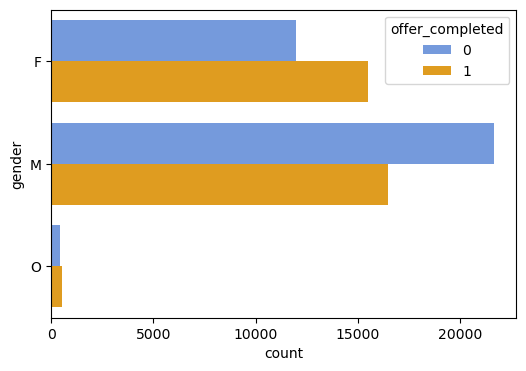

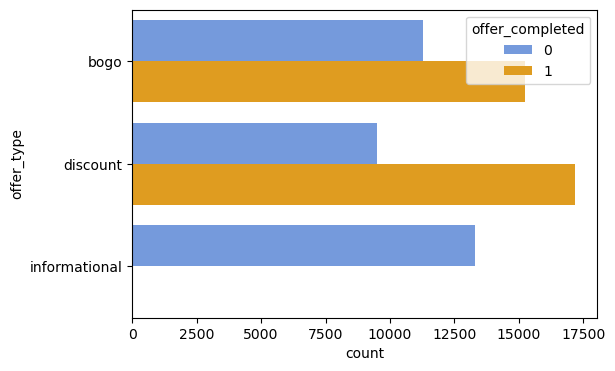

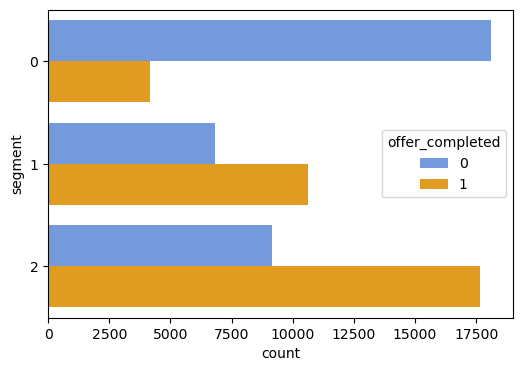

In [256]:
check_cat_cols_distribution(full_data)

- Given that all informational offers were not completed, it could be an indication that this offer type was not meant to be completed.
- As such, all offer records with "informational" offer_type will be removed from the regression dataset. 

In [257]:
# Remove offer records with "informational" offer_type
full_data_rm_info = full_data.copy()[full_data["offer_type"] != "informational"].reset_index(drop=True)

In [258]:
def plot_completion_response_distribution(data):
    count_df = data["offer_completed"].value_counts().reset_index()
    response_label = list(count_df["offer_completed"])
    response_count = list(count_df["count"])
    plt.figure(figsize=(2, 2))
    plt.pie(response_count, labels=response_label, autopct='%1.2f%%', colors=["orange", "cornflowerblue"])
    plt.show()

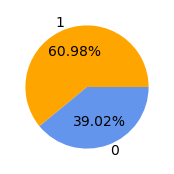

In [259]:
# Overall distribution of response variable in full_data_rm_info
plot_completion_response_distribution(full_data_rm_info)

Num. records excluded (1st week data):  8828
Num. records in filtered dataset:  44373


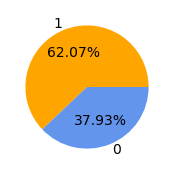

In [260]:
# Exclude data from 1st week
first_wk_data = full_data_rm_info[full_data_rm_info ["received_time"] < (24*7)]
print("Num. records excluded (1st week data): ", len(first_wk_data))
data = full_data_rm_info[full_data_rm_info["received_time"] >= (24*7)].reset_index(drop=True)
print("Num. records in filtered dataset: ", len(data))
# Check distribution of response variable in data after 1st week removal
plot_completion_response_distribution(data)

In [261]:
check_num_cols_mean(data)

,age,income_k,reward,difficulty,duration,num_channels,txn_amt,used_email,used_web,used_social,used_mobile,offer_viewed,received_time,time_since_last_txn,last_txn_amt,ave_txn_amt,num_txn_past_week,num_offers_past_week
offer_completed,,,,,,,,,,,,,,,,,,
0,51.84,58.69,5.72,10.18,7.17,3.28,NaN,1.0,0.86,0.59,0.84,0.65,398.94,8.11,7.46,7.34,1.70,1.05
1,55.87,69.47,4.96,9.30,7.31,3.43,20.92,1.0,0.89,0.64,0.90,0.81,398.56,5.11,16.67,16.63,2.21,1.05


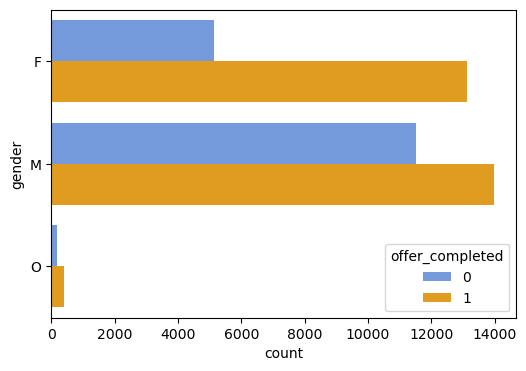

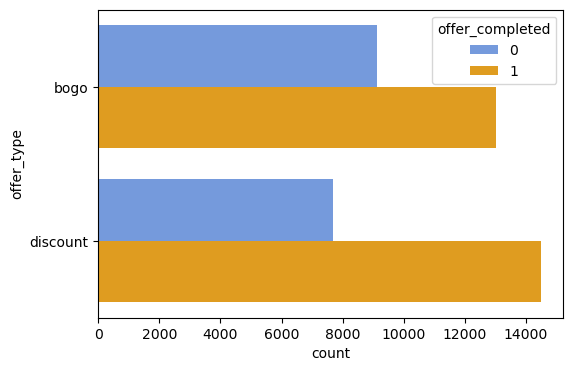

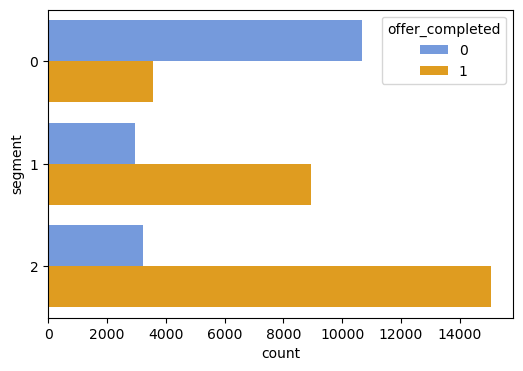

In [262]:
check_cat_cols_distribution(data)

#### Select variables

- Independent variables should be independent of each other and avoid multicollinearity
- Independent variables are linearly related of the log odds of customer acting on offer

In [263]:
# Remove columns not needed (person, offer_id, received_time, txn_amt)
# Remove "used_email" as all offers were sent through email
# Drop last_txn_amt as both it and ave_txn_amt are not independent. Retain only ave_txn_amt. 
logreg_data = data.copy().drop(columns=["person", "offer_id", "received_time", "used_email", "last_txn_amt"])

# Convert categorical variables to numeric form using one-hot encoding (regression requires all variables to be numeric)
# Drop 1 level of dummmy variable to avoid perfect multicollinearity
logreg_data= pd.concat([logreg_data, pd.get_dummies(logreg_data["gender"], prefix="is", dtype=int, drop_first=True)], axis=1)
logreg_data = pd.concat([logreg_data, pd.get_dummies(logreg_data["offer_type"], prefix="is", dtype=int, drop_first=True)], axis=1)

# Drop original categorical variables
logreg_data = logreg_data.drop(columns=["gender", "offer_type"])

In [264]:
logreg_data.corr()

,offer_completed,segment,age,income_k,reward,difficulty,duration,num_channels,txn_amt,used_web,used_social,used_mobile,offer_viewed,time_since_last_txn,ave_txn_amt,num_txn_past_week,num_offers_past_week,is_M,is_O,is_discount
offer_completed,1.000000,0.490618,0.112683,0.241885,-0.123605,-0.095617,0.037011,0.099278,NaN,0.046141,0.052904,0.085173,0.182986,-0.158584,0.232131,0.130840,-0.005909,-0.173815,0.019654,0.067305
segment,0.490618,1.000000,0.315434,0.583097,0.002374,-0.021599,-0.009740,0.029441,0.137972,-0.007289,0.028839,0.026963,0.150456,-0.005699,0.328098,0.043251,-0.006417,-0.225865,0.010816,-0.006671
age,0.112683,0.315434,1.000000,0.306057,0.000682,-0.001457,-0.001056,0.001704,0.061789,0.000616,0.001265,0.001117,0.033928,0.064364,0.137588,-0.105888,-0.003935,-0.154148,0.002206,-0.002152
income_k,0.241885,0.583097,0.306057,1.000000,0.000780,-0.002040,-0.003449,0.001345,0.146240,-0.000757,0.000174,0.003325,0.040534,0.099263,0.342697,-0.176410,-0.009572,-0.222828,-0.013224,-0.002342
reward,-0.123605,0.002374,0.000682,0.000780,1.000000,0.063734,-0.455474,-0.045549,0.038213,-0.601610,0.323614,0.031643,0.125261,-0.004749,0.001890,0.006078,-0.004222,-0.000478,-0.002203,-0.752194
difficulty,-0.095617,-0.021599,-0.001457,-0.002040,0.063734,1.000000,0.642954,-0.682012,0.048548,-0.031371,-0.354318,-0.883432,-0.303744,0.003820,0.002408,-0.004592,-0.006303,-0.002661,0.003689,0.478376
duration,0.037011,-0.009740,-0.001056,-0.003449,-0.455474,0.642954,1.000000,-0.479467,0.005363,0.053922,-0.325977,-0.584506,-0.235493,0.004030,-0.002776,-0.007176,-0.000826,0.001149,0.004696,0.698573
num_channels,0.099278,0.029441,0.001704,0.001345,-0.045549,-0.682012,-0.479467,1.000000,-0.034941,0.201984,0.788100,0.747121,0.509750,-0.005275,-0.002863,0.006968,0.006566,0.003590,-0.008238,-0.178007
txn_amt,NaN,0.137972,0.061789,0.146240,0.038213,0.048548,0.005363,-0.034941,1.000000,-0.023252,-0.008429,-0.039634,-0.006926,0.020256,0.084560,-0.047537,0.000087,-0.034470,-0.003923,-0.007473
used_web,0.046141,-0.007289,0.000616,-0.000757,-0.601610,-0.031371,0.053922,0.201984,-0.023252,1.000000,-0.294275,-0.143457,-0.103989,0.001143,0.001114,0.000664,-0.000101,-0.003577,-0.001730,0.378665


In [265]:
# Drop highly correlated columns
logreg_data = logreg_data.drop(columns=["num_channels", "used_mobile", "is_discount"])
logreg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44373 entries, 0 to 44372
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_completed       44373 non-null  int64  
 1   segment               44373 non-null  object 
 2   age                   44373 non-null  int64  
 3   income_k              44373 non-null  float64
 4   reward                44373 non-null  int64  
 5   difficulty            44373 non-null  int64  
 6   duration              44373 non-null  int64  
 7   txn_amt               27542 non-null  float64
 8   used_web              44373 non-null  int64  
 9   used_social           44373 non-null  int64  
 10  offer_viewed          44373 non-null  int64  
 11  time_since_last_txn   44373 non-null  float64
 12  ave_txn_amt           44373 non-null  float64
 13  num_txn_past_week     44373 non-null  int64  
 14  num_offers_past_week  44373 non-null  int64  
 15  is_M               

#### Logistic Regression (predict offer completion)

In [266]:
def perform_log_reg(data, segment):
    # Train-test-split
    training_data = data.copy()
    # Only include data from a particular segment
    training_data = training_data[training_data["segment"] == segment].reset_index(drop=True)

    print("% of offers completed:")
    plot_completion_response_distribution(training_data)
    # Drop columns not needed
    training_data = training_data.drop(columns=["segment", "txn_amt"])
    response_var = training_data.pop("offer_completed")
    X_train, X_test, y_train, y_test = train_test_split(training_data, response_var, test_size=0.1, random_state=45)

    # Check distribution of response variable (train dataset)
    print("Num. records (train): ", len(y_train))
    plot_completion_response_distribution(y_train.reset_index(name="offer_completed"))

    # Check distribution of response variable (test dataset)
    print("\nNum. records (test): ", len(y_test))
    plot_completion_response_distribution(y_test.reset_index(name="offer_completed"))

    # Obtain regression results
    logit_model = sm.Logit(endog=y_train, exog=X_train)
    logit_model_results = logit_model.fit()
    print(logit_model_results.summary2())

    # Get model performance metrics
    log_reg_model = LogisticRegression(random_state=45)
    log_reg_model.fit(X_train, y_train)
    y_pred = log_reg_model.predict(X_test)
    print('Accuracy on test set: {:.2f}'.format(log_reg_model.score(X_test, y_test)))
    print(classification_report(y_test, y_pred))

% of offers completed:


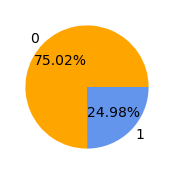

Num. records (train):  12792


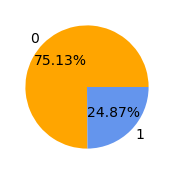


Num. records (test):  1422


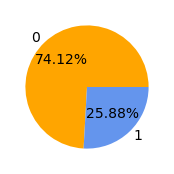

Optimization terminated successfully.
         Current function value: 0.522456
         Iterations 6
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.069      
Dependent Variable:  offer_completed   AIC:               13394.5163 
Date:                2024-04-20 21:42  BIC:               13498.9083 
No. Observations:    12792             Log-Likelihood:    -6683.3    
Df Model:            13                LL-Null:           -7175.8    
Df Residuals:        12778             LLR p-value:       2.9045e-202
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      6.0000                                          
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
age                  -0.0012   0.0012  -1.0183 0.3086 -0.0036  0.0011
income_k        

In [267]:
perform_log_reg(logreg_data, "0")

% of offers completed:


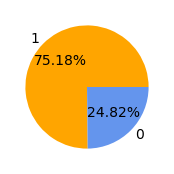

Num. records (train):  10697


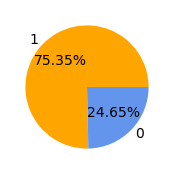


Num. records (test):  1189


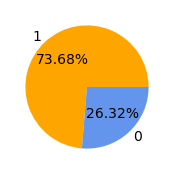

Optimization terminated successfully.
         Current function value: 0.379072
         Iterations 7
                           Results: Logit
Model:                 Logit             Pseudo R-squared:  0.321    
Dependent Variable:    offer_completed   AIC:               8137.8712
Date:                  2024-04-20 21:42  BIC:               8239.7593
No. Observations:      10697             Log-Likelihood:    -4054.9  
Df Model:              13                LL-Null:           -5974.0  
Df Residuals:          10683             LLR p-value:       0.0000   
Converged:             1.0000            Scale:             1.0000   
No. Iterations:        7.0000                                        
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
age                   0.0007   0.0015   0.4493 0.6532 -0.0023  0.0037
income_k        

In [268]:
perform_log_reg(logreg_data, "1")

% of offers completed:


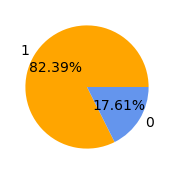

Num. records (train):  16445


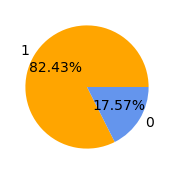


Num. records (test):  1828


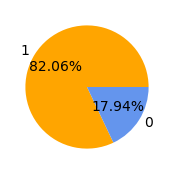

Optimization terminated successfully.
         Current function value: 0.408241
         Iterations 6
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.122     
Dependent Variable:   offer_completed   AIC:               13455.0466
Date:                 2024-04-20 21:42  BIC:               13562.9555
No. Observations:     16445             Log-Likelihood:    -6713.5   
Df Model:             13                LL-Null:           -7643.2   
Df Residuals:         16431             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
age                   0.0027   0.0016   1.7200 0.0854 -0.0004  0.0059
income_k        

In [269]:
perform_log_reg(logreg_data, "2")

#### Linear Regression (predict transaction amount)

In [270]:
linreg_data = logreg_data.copy()
# Only retain offers that were completed
linreg_data = linreg_data[linreg_data["offer_completed"] == 1].reset_index(drop=True)
# linreg_data.info()

In [271]:
linreg_data["txn_amt"].describe()

count    27542.000000
mean        20.919380
std         41.088347
min          0.150000
25%         11.440000
50%         17.060000
75%         23.620000
max       1015.730000
Name: txn_amt, dtype: float64

In [272]:
# Remove transaction amount outliers
linreg_data = linreg_data[linreg_data["txn_amt"] <= 100].reset_index(drop=True)
# Remove ave_txn_amt to avoid data leakage
linreg_data = linreg_data.drop(columns=["ave_txn_amt", "offer_completed"])

In [273]:
# for col in linreg_data.columns.to_list():
#     sns.scatterplot(data=linreg_data, x=col, y="txn_amt")
#     plt.show()

In [274]:
def perform_lin_reg(data, segment):
    # Train-test-split
    training_data = data.copy()
    # Only include data from a particular segment
    training_data = training_data[training_data["segment"] == segment].reset_index(drop=True)

    print("Average transaction amount ($): ", round(training_data["txn_amt"].mean(), 2))
    # Drop columns not needed
    training_data = training_data.drop(columns=["segment"])
    response_var = training_data.pop("txn_amt")
    X_train, X_test, y_train, y_test = train_test_split(training_data, response_var, test_size=0.1, random_state=45)

    # Obtain regression results
    ols_model = sm.OLS(endog=y_train, exog=X_train)
    ols_model_results = ols_model.fit()
    print(ols_model_results.summary2())

    # Get model performance metrics
    lin_reg_model = LinearRegression()
    lin_reg_model.fit(X_train, y_train)
    y_pred = lin_reg_model.predict(X_test)
    print('RMSE: {:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

In [275]:
perform_lin_reg(linreg_data, "0")

Average transaction amount ($):  13.2
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.702     
Dependent Variable:     txn_amt          AIC:                         22955.7310
Date:                   2024-04-20 21:42 BIC:                         23034.5467
No. Observations:       3174             Log-Likelihood:              -11465.   
Df Model:               13               F-statistic:                 575.8     
Df Residuals:           3161             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.703            Scale:                       80.678    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
age                       0.0219     0.0092    2.3813   0.0173    0.0039    0.0400
income_

In [276]:
perform_lin_reg(linreg_data, "1")

Average transaction amount ($):  12.65
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.725     
Dependent Variable:     txn_amt          AIC:                         55782.6140
Date:                   2024-04-20 21:42 BIC:                         55873.4215
No. Observations:       7984             Log-Likelihood:              -27878.   
Df Model:               13               F-statistic:                 1618.     
Df Residuals:           7971             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.725            Scale:                       63.263    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
age                       0.0050     0.0051    0.9745   0.3299   -0.0051    0.0150
income

In [277]:
perform_lin_reg(linreg_data, "2")

Average transaction amount ($):  22.2
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.922     
Dependent Variable:     txn_amt          AIC:                         88656.3068
Date:                   2024-04-20 21:42 BIC:                         88753.8828
No. Observations:       13438            Log-Likelihood:              -44315.   
Df Model:               13               F-statistic:                 1.225e+04 
Df Residuals:           13425            Prob (F-statistic):          0.00      
R-squared (uncentered): 0.922            Scale:                       42.888    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
age                      -0.0045     0.0041   -1.0955   0.2733   -0.0124    0.0035
income_